In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.interpolate import RegularGridInterpolator
import matplotlib.ticker as ticker


# Load the data
spectral_data = np.load('./data/allen_cahn_ref.npy', allow_pickle=True).item()
pikan_data = np.load('./data/allen_cahn_pikan_nx320_nt160_[2, 9, 9, 1]_epochs150000_k5.npy', allow_pickle=True).item()
spikan1_data = np.load('./data/allen_cahn_spikan_nx320_nt160_[1, 5, 5, 1]_epochs150000_k5_r5.npy', allow_pickle=True).item()
spikan2_data = np.load('./data/allen_cahn_spikan_nx320_nt160_[1, 5, 5, 1]_epochs150000_k5_r10.npy', allow_pickle=True).item()
spikan3_data = np.load('./data/allen_cahn_spikan_nx320_nt160_[1, 5, 5, 1]_epochs150000_k5_r20.npy', allow_pickle=True).item()





In [2]:
# Plotting setup
plt.rcParams.update({
    'font.size': 12,                      # Base font size
    'axes.titlesize': 12,                 # Font size for titles
    'axes.labelsize': 12,                 # Font size for axis labels
    'xtick.labelsize': 10,                # Font size for x-tick labels
    'ytick.labelsize': 10,                # Font size for y-tick labels
    'legend.fontsize': 12,                # Font size for legends
})

def set_tick_format(ax, cbar, decimals=2):
    """
    Set the number of decimal places for x and y ticks on the axis,
    and for the colorbar ticks.
    
    Parameters:
    - ax: The Matplotlib axis object.
    - cbar: The colorbar object associated with the axis.
    - decimals: Number of decimal places to display.
    """
    formatter = ticker.FormatStrFormatter(f'%.{decimals}f')
    
    # Set formatter for x and y ticks
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    
    # Set formatter for colorbar ticks
    cbar.ax.yaxis.set_major_formatter(formatter)

def interpolate_to_reference_grid(data, ref_t, ref_x):
    """
    Interpolate data to match the reference grid using RegularGridInterpolator.
    Handles JAX arrays by converting to numpy arrays.
    
    Parameters:
    - data: Dictionary containing 't', 'x', and 'u' arrays
    - ref_t: Reference time grid
    - ref_x: Reference spatial grid
    
    Returns:
    - Interpolated u values on reference grid
    """
    # Convert JAX arrays to numpy arrays
    t = np.array(data['t'])
    x = np.array(data['x'])
    u = np.array(data['u'])
    ref_t = np.array(ref_t)
    ref_x = np.array(ref_x)
    
    # Create interpolation function
    interp_func = RegularGridInterpolator(
        (t, x),
        u,
        method='linear',
        bounds_error=False,
        fill_value=None
    )
    
    # Create meshgrid of reference points
    T_ref, X_ref = np.meshgrid(ref_t, ref_x, indexing='ij')
    points = np.stack((T_ref.flatten(), X_ref.flatten()), axis=1)
    
    # Interpolate to reference grid
    u_interp = interp_func(points).reshape(T_ref.shape)
    return u_interp

L2 Error (PIKAN): 52.918
L2 Error (SPIKAN (a)): 94.179
L2 Error (SPIKAN (b)): 17.150
L2 Error (SPIKAN (c)): 28.536


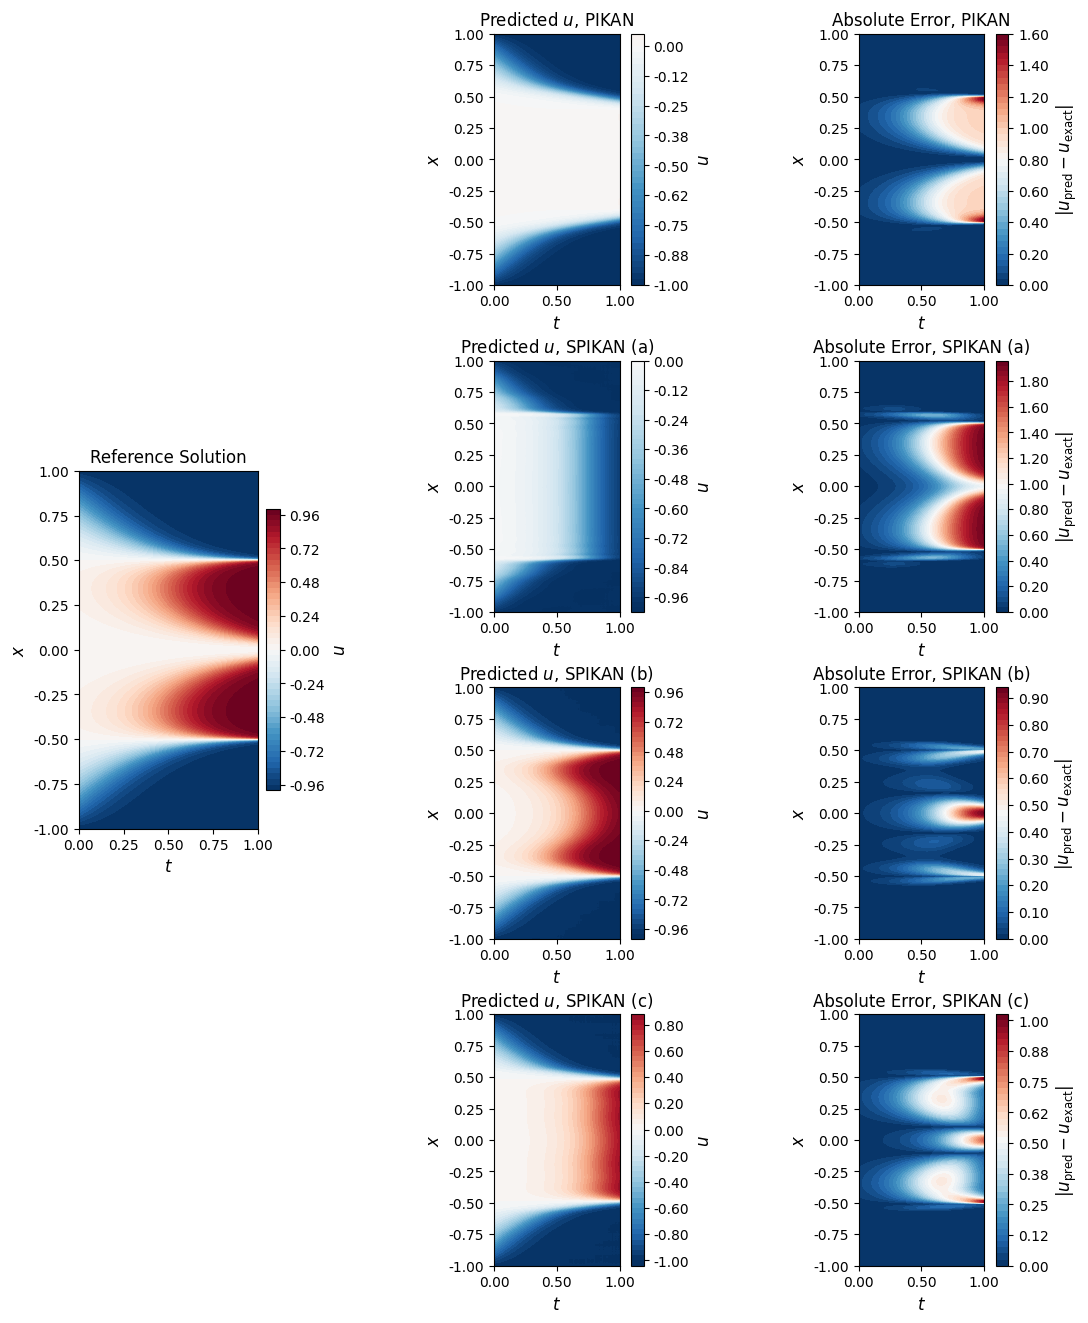

In [4]:
# Create meshgrid for reference solution
T_spectral, X_spectral = np.meshgrid(spectral_data['t'], spectral_data['x'], indexing='ij')

# Interpolate all solutions to reference grid and compute errors
solutions = {
    'PIKAN': pikan_data,
    'SPIKAN (a)': spikan1_data,
    'SPIKAN (b)': spikan2_data,
    'SPIKAN (c)': spikan3_data
}

interpolated_solutions = {}
errors = {}
l2_errors = {}

for name, data in solutions.items():
    # Interpolate solution to reference grid
    u_interp = interpolate_to_reference_grid(data, spectral_data['t'], spectral_data['x'])
    interpolated_solutions[name] = u_interp
    
    # Compute errors
    errors[name] = np.abs(u_interp - spectral_data['u'])
    l2_errors[name] = 100 * np.sqrt(np.mean((u_interp - spectral_data['u'])**2)) / np.sqrt(np.mean(spectral_data['u']**2))
    print(f"L2 Error ({name}): {l2_errors[name]:.3f}")

# Create figure with updated layout for 4 rows
fig = plt.figure(figsize=(12, 16))
gs = gridspec.GridSpec(4, 3, width_ratios=[0.7, 1, 1], wspace=0.3, hspace=0.3)

# Plot Reference solution
ax_reference = plt.subplot(gs[:, 0])
im_reference = ax_reference.contourf(T_spectral, X_spectral, spectral_data['u'], 
                                   levels=50, cmap='RdBu_r', vmin=-1, vmax=1)
cbar_reference = plt.colorbar(im_reference, ax=ax_reference, fraction=0.07, pad=0.04)
cbar_reference.set_label(r'$u$')
ax_reference.set_title(r'Reference Solution')
ax_reference.set_aspect('equal')
ax_reference.set_xlabel(r'$t$')
ax_reference.set_ylabel(r'$x$')
set_tick_format(ax_reference, cbar_reference)

# Plot each solution and its error
for idx, (name, u_interp) in enumerate(interpolated_solutions.items()):
    # Solution plot
    ax_pred = plt.subplot(gs[idx, 1])
    im_pred = ax_pred.contourf(T_spectral, X_spectral, u_interp, 
                              levels=50, cmap='RdBu_r', vmin=-1, vmax=1)
    cbar_pred = plt.colorbar(im_pred, ax=ax_pred, fraction=0.046, pad=0.04)
    cbar_pred.set_label(r'$u$')
    ax_pred.set_title(f'Predicted $u$, {name}')
    ax_pred.set_aspect('equal')
    ax_pred.set_xlabel(r'$t$')
    ax_pred.set_ylabel(r'$x$')
    set_tick_format(ax_pred, cbar_pred)
    
    # Error plot
    ax_error = plt.subplot(gs[idx, 2])
    im_error = ax_error.contourf(T_spectral, X_spectral, errors[name], 
                                levels=50, cmap='RdBu_r')
    cbar_error = plt.colorbar(im_error, ax=ax_error, fraction=0.046, pad=0.04)
    cbar_error.set_label(r'$|u_{\text{pred}} - u_{\text{exact}}|$')
    ax_error.set_title(f'Absolute Error, {name}')
    ax_error.set_aspect('equal')
    ax_error.set_xlabel(r'$t$')
    ax_error.set_ylabel(r'$x$')
    set_tick_format(ax_error, cbar_error)

plt.savefig('./results/comparison_allencahn.png', dpi=600, bbox_inches='tight')
plt.show()
